# Considerações
**Altura de cada andar: 3m (exceto subsolo e área serviço)**

**Considera o valor "4" uma vez por considerar apenas a área de serviço**

**Então, erro máximo = 4 + 3 x (8-1) = 25**

**A faixa de tolerância é entre 0 e 10 cm, tendo o valor de pertinência igual a 1. Entre 10 cm e 20 cm, terá uma pertinência.**

<img src="Assets/prédio.png" style="height:500px;width:400px">

# Integrantes

**Matheus Camara Carvalho**

**Igor da Silva Villamarim**

**Gabriel de Souza Gemelle Leal**

### 1. Instalando bibliotecas necessárias

In [117]:
%pip install paho-mqtt scikit-fuzzy python-dotenv tabulate pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### 2. Importação de bibliotecas

In [118]:
# Importa a biblioteca os para interagir com o sistema operacional
import os
# Importa a função load_dotenv para carregar variáveis de ambiente de um arquivo .env
from dotenv import load_dotenv
# Importa a biblioteca numpy para operações numéricas
import numpy as np
# Importa a biblioteca skfuzzy para controle fuzzy
import skfuzzy as fuzzy
# Importa a biblioteca time para operações relacionadas ao tempo
import time
# Importa a biblioteca paho.mqtt.client para comunicação MQTT
import paho.mqtt.client as paho
# Importa a biblioteca itertools para operações com iteradores eficientes
import itertools
# Importa o módulo mqtt do paho para comunicação MQTT
from paho import mqtt
# Importa o módulo control do skfuzzy para controle fuzzy
from skfuzzy import control as ctrl
# Importa a biblioteca matplotlib.pyplot para criação de gráficos
import matplotlib.pyplot as plt
# Importa a biblioteca tkinter para a criação de interfaces gráficas
import tkinter as tk
# Importa o módulo messagebox do tkinter para exibir caixas de mensagens
from tkinter import messagebox
# Importa a função clear_output do IPython.display para limpar a saída do Jupyter notebook
from IPython.display import clear_output
# Importa a biblioteca re para suporte ao reconhecimento de expressões regulares
import re
# Importa a biblioteca pandas para manipulação de DataFrames
import pandas as pd
# Importa a função tabulate da biblioteca tabulate para manipulação de tabelas
from tabulate import tabulate

### 3. Iniciando variáveis mqtt e o HiveMQ

In [119]:
# Especificar o caminho do arquivo .env
dotenv_path = 'Variables.env'
if not os.path.exists(dotenv_path):
    raise FileNotFoundError(f"Arquivo {dotenv_path} não encontrado.")

load_dotenv(dotenv_path)

# Obtém as variáveis de ambiente - Segurança adicional para evitar o vazamento das credenciais em texto claro
mqtt_username = os.getenv('MQTT_USERNAME')
mqtt_password = os.getenv('MQTT_PASSWORD')
mqtt_url = os.getenv('MQTT_URL')
mqtt_port = os.getenv('MQTT_PORT')

# Verificar se todas as variáveis de ambiente foram carregadas corretamente
if not all([mqtt_username, mqtt_password, mqtt_url, mqtt_port]):
    raise ValueError("Uma ou mais variáveis de ambiente não foram carregadas corretamente.")

mqtt_port = int(mqtt_port)  # Converter para inteiro

# Definindo callbacks para diferentes eventos para ver se funciona, imprimir a mensagem etc.
def on_connect(client, userdata, flags, rc, properties=None):
    if rc == 0:
        print("Conexão estabelecida com sucesso!")
    else:
        print("CONNACK received with code %s." % rc)

# Com este callback você pode ver se sua publicação foi bem-sucedida
#def on_publish(client, userdata, mid, properties=None):
#   print(f"Publicação realizada com sucesso! (mid={mid})")

# Imprimir qual tópico foi inscrito
def on_subscribe(client, userdata, mid, granted_qos, properties=None):
    print("Subscribed: " + str(mid) + " " + str(granted_qos))

# Imprimir mensagem, útil para verificar se foi bem-sucedido
def on_message(client, userdata, msg):
    print(msg.topic + " " + str(msg.qos) + " " + str(msg.payload))

client = paho.Client(client_id="", userdata=None, protocol=paho.MQTTv5)
client.on_connect = on_connect  

# Habilita o TLS para uma conexão segura (diferencial) 
client.tls_set(tls_version=mqtt.client.ssl.PROTOCOL_TLS)

# Configurar nome de usuário e senha
client.username_pw_set(mqtt_username, mqtt_password)
# Conectar ao HiveMQ Cloud na porta especificada
try:
    client.connect(mqtt_url, mqtt_port)
except Exception as e:
    print(f"Erro ao conectar: {e}")

client.publish("elevador/AndarAtual", payload="clear")
client.publish("elevador/ErroAtual", payload="clear")
# Configurar callbacks
client.on_subscribe = on_subscribe
client.on_message = on_message
#client.on_publish = on_publish

/tmp/ipykernel_6105/2468476709.py:39: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = paho.Client(client_id="", userdata=None, protocol=paho.MQTTv5)


### 4. Variáveis de Erro

([], [])

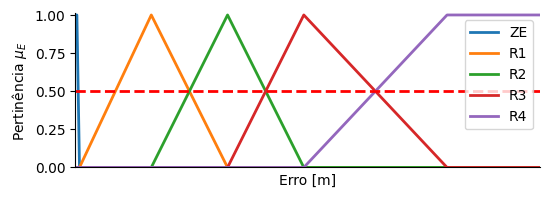

In [120]:
# Erro máximo = 25
# Os valores estão referenciados em cm, valores decimais não são suficientes

# Variável erro de entrada do sistema de controle
Erro = ctrl.Antecedent(universe=np.arange(0, 25.01, 0.01), label='Erro')

# Funções de pertinência para diferentes categorias de erro
# fuzzy.trapmf = função de pertinência trapezoidal
# fuzzy.trimf = função de pertinência triangular
Erro['ZE'] = fuzzy.trapmf(Erro.universe, [0, 0, 0.1, 0.24])  # Zero Error
Erro['R1'] = fuzzy.trimf(Erro.universe, [0.24, 4.1, 8.2])    # Regular 1
Erro['R2'] = fuzzy.trimf(Erro.universe, [4.1, 8.2, 12.3])      # Regular 2
Erro['R3'] = fuzzy.trimf(Erro.universe, [8.2, 12.3, 20.0])      # Regular 3
Erro['R4'] = fuzzy.trapmf(Erro.universe, [12.3, 20.0, 25.0, 25.0])     # Regular 4

# Visualização da função de pertinência
Erro.view()

# Adiciona uma linha pontilhada vermelha horizontal em y=0.5 para mostrar onde as funções cruzam esse ponto
plt.axhline(y=0.5, color='r', linestyle='--')

# Aumenta a espessura das linhas do gráfico
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]

# A linha em 0.5 no eixo horizontal serve apenas para mostrar que as funções cruzam nesse ponto
figura = plt.gcf()  # Obtém a figura atual
axes = figura.gca()  # Obtém os eixos atuais da figura
figura.set_size_inches(6, 2)  # Define o tamanho da figura como 6 polegadas de largura por 2 polegadas de altura
axes.set_xlabel(xlabel='Erro [m]')  # Define o rótulo do eixo x como Erro [m]
axes.set_ylabel(ylabel='Pertinência $\mu_{E}$')  # Define o rótulo do eixo y como Pertinência_mu_E
plt.legend(loc='upper right')  # Adiciona a legenda no canto superior direito do gráfico
plt.savefig('Output/Erro.png')  # Salva a figura como um arquivo PNG no diretório Output
plt.xticks([])  # Remove os marcadores no eixo x


### 5. Variáveis de ∆Erro

([], [])

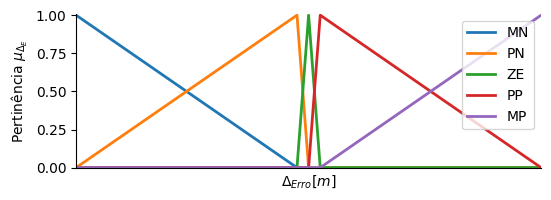

In [121]:
# Como a tolerância foi de 10cm, o delta erro de tolerância também será o dobro (ZE)

# Variável delta erro de entrada do sistema de controle
dErro = ctrl.Antecedent(universe=np.arange(-25, 25.1, 0.1), label='DeltaErro')

# Funções de pertinência para diferentes categorias de erro
dErro['MN'] = fuzzy.trapmf(dErro.universe, [-25, -25, -2.0, -0.1])  # Muito Negativo
dErro['PN'] = fuzzy.trimf(dErro.universe, [-2.0, -0.1, 0])         # Pouco Negativo
dErro['ZE'] = fuzzy.trimf(dErro.universe, [-0.1, 0, 0.1])         # Zero
dErro['PP'] = fuzzy.trimf(dErro.universe, [0, 0.1, 2.0])           # Pouco Positivo
dErro['MP'] = fuzzy.trapmf(dErro.universe, [0.1, 2.0, 25, 25])      # Muito Positivo

# Visualização da função de pertinência
dErro.view()

# Ajustes estéticos para a visualização do gráfico

[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]  # Aumenta a espessura das linhas do gráfico
figura = plt.gcf()  # Obtém a figura atual
axes = figura.gca()  # Obtém os eixos atuais da figura
axes.set_xlim([-2, 2])  # Define os limites do eixo x de -2 a 2
figura.set_size_inches(6, 2)  # Define o tamanho da figura como 6 polegadas de largura por 2 polegadas de altura
axes.set_xlabel(xlabel='$\Delta_{Erro} [m]$')  # Define o rótulo do eixo x como Delta_Erro [m]
axes.set_ylabel(ylabel='Pertinência $\mu_{\Delta_{E}}$')  # Define o rótulo do eixo y como Pertinência_mu_Delta_E
plt.legend(loc='upper right')  # Adiciona a legenda no canto superior direito do gráfico
plt.savefig('Output/DeltaErro.png')  # Salva a figura como um arquivo PNG no diretório Output
plt.xticks([])  # Remove os marcadores no eixo x

### 6. Variáveis da Potência do Motor

([], [])

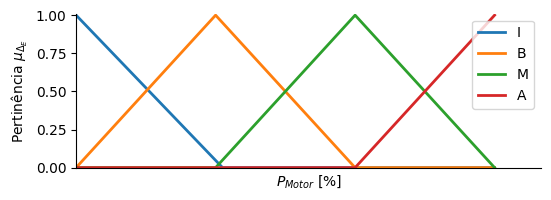

In [122]:
# Definição da variável de saída PotenciaMotor
PotenciaMotor = ctrl.Consequent(universe=np.arange(0, 90.5, 0.5), label='PotenciaMotor')

# Funções de pertinência para diferentes categorias de potência do motor
PotenciaMotor['I'] = fuzzy.trimf(PotenciaMotor.universe, [0, 0, 31.5])   # Inicial
PotenciaMotor['B'] = fuzzy.trimf(PotenciaMotor.universe, [0, 30, 60])  # Baixa
PotenciaMotor['M'] = fuzzy.trimf(PotenciaMotor.universe, [30, 60, 90]) # Média
PotenciaMotor['A'] = fuzzy.trimf(PotenciaMotor.universe, [60, 90, 90]) # Alta   

# Visualização da função de pertinência
PotenciaMotor.view()

# Ajustes estéticos para a visualização do gráfico
[plt.gca().lines[i].set_linewidth(2) for i in range(len(plt.gca().lines))]  # Aumenta a espessura das linhas do gráfico
figura = plt.gcf()  # Obtém a figura atual
axes = figura.gca()  # Obtém os eixos atuais da figura
figura.set_size_inches(6, 2)  # Define o tamanho da figura como 6 polegadas de largura por 2 polegadas de altura
axes.set_xlabel(xlabel='$P_{Motor}$ [%]')  # Define o rótulo do eixo x como PotenciaMotor [%]
axes.set_xlim([0, 100])  # Define os limites do eixo x de 0 a 100
axes.set_ylabel(ylabel='Pertinência $\mu_{\Delta_{E}}$')  # Define o rótulo do eixo y como Pertinência_mu_Delta_E
plt.legend(loc='upper right')  # Adiciona a legenda no canto superior direito do gráfico
plt.savefig('Output/Aceleração.png')  # Salva a figura como um arquivo PNG no diretório Output
plt.xticks([])  # Remove os marcadores no eixo x


### 7. Base de Regras

In [123]:
import skfuzzy as fuzz
import skfuzzy.control as ctrl

# Regras do sistema de controle fuzzy
# Regras para quando dErro é 'MN'
R1 = ctrl.Rule(Erro['ZE'] & dErro['MN'], PotenciaMotor['I'])
R2 = ctrl.Rule(Erro['ZE'] & dErro['PN'], PotenciaMotor['I'])
R3 = ctrl.Rule(Erro['ZE'] & dErro['ZE'], PotenciaMotor['I'])
R4 = ctrl.Rule(Erro['ZE'] & dErro['PP'], PotenciaMotor['I'])
R5 = ctrl.Rule(Erro['ZE'] & dErro['MP'], PotenciaMotor['I'])

# Regras para quando dErro é 'PN'
R6 = ctrl.Rule(Erro['R1'] & dErro['MN'], PotenciaMotor['B'])
R7 = ctrl.Rule(Erro['R1'] & dErro['PN'], PotenciaMotor['B'])
R8 = ctrl.Rule(Erro['R1'] & dErro['ZE'], PotenciaMotor['I'])
R9 = ctrl.Rule(Erro['R1'] & dErro['PP'], PotenciaMotor['B'])
R10 = ctrl.Rule(Erro['R1'] & dErro['MP'], PotenciaMotor['B'])

# Regras para quando dErro é 'ZE'
R11 = ctrl.Rule(Erro['R2'] & dErro['MN'], PotenciaMotor['M'])
R12 = ctrl.Rule(Erro['R2'] & dErro['PN'], PotenciaMotor['B'])
R13 = ctrl.Rule(Erro['R2'] & dErro['ZE'], PotenciaMotor['I'])
R14 = ctrl.Rule(Erro['R2'] & dErro['PP'], PotenciaMotor['B'])
R15 = ctrl.Rule(Erro['R2'] & dErro['MP'], PotenciaMotor['M'])

# Regras para quando dErro é 'PP'
R16 = ctrl.Rule(Erro['R3'] & dErro['MN'], PotenciaMotor['M'])
R17 = ctrl.Rule(Erro['R3'] & dErro['PN'], PotenciaMotor['B'])
R18 = ctrl.Rule(Erro['R3'] & dErro['ZE'], PotenciaMotor['I'])
R19 = ctrl.Rule(Erro['R3'] & dErro['PP'], PotenciaMotor['B'])
R20 = ctrl.Rule(Erro['R3'] & dErro['MP'], PotenciaMotor['M'])

# Regras para quando dErro é 'MP'
R21 = ctrl.Rule(Erro['R4'] & dErro['MN'], PotenciaMotor['A'])
R22 = ctrl.Rule(Erro['R4'] & dErro['PN'], PotenciaMotor['M'])
R23 = ctrl.Rule(Erro['R4'] & dErro['ZE'], PotenciaMotor['I'])
R24 = ctrl.Rule(Erro['R4'] & dErro['PP'], PotenciaMotor['M'])
R25 = ctrl.Rule(Erro['R4'] & dErro['MP'], PotenciaMotor['A'])


qtdRegras = len(Erro.terms)*len(dErro.terms)
BaseRegras = [globals()[f'R{i}'] for i in range(1, qtdRegras + 1)]

# Inicialização da simulação do sistema de controle
BaseRegras


[IF Erro[ZE] AND DeltaErro[MN] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[ZE] AND DeltaErro[PN] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[ZE] AND DeltaErro[ZE] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[ZE] AND DeltaErro[PP] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[ZE] AND DeltaErro[MP] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[R1] AND DeltaErro[MN] THEN PotenciaMotor[B]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[R1] AND DeltaErro[PN] THEN PotenciaMotor[B]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[R1] AND DeltaErro[ZE] THEN PotenciaMotor[I]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF Erro[R1] AND DeltaEr

### 8. Print da Base de Regras

In [124]:
# Inicialização da lista de tabelas
tabela = []

vermelho, verde, amarelo, azul, magenta, ciano = ['\033[91m', '\033[92m', '\033[93m', '\033[94m', '\033[95m', '\033[96m']

# Iteração pelos termos de Erro e dErro
for erro in Erro.terms:
    for derro in dErro.terms:
        for regra in BaseRegras:
            antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
            consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

            classificacoes = re.findall(r'\[(.*?)\]', (antecedente + consequente))
            if erro == classificacoes[0] and derro == classificacoes[1]:
                tabela.append([classificacoes[0], classificacoes[1], classificacoes[2]])
                break  # Sai do loop de regras após encontrar uma correspondência

# Criação do DataFrame
df = pd.DataFrame(tabela, columns=['Erro', 'dErro', 'PotenciaMotor'])

# Criação da pivotTable
pivotTable = pd.DataFrame(df.pivot(index='dErro', columns='Erro', values='PotenciaMotor')
                          .reindex(index=dErro.terms, columns=Erro.terms))

# Configuração do nome do índice
pivotTable.index.name = f'{magenta}dErro/erro\033[0m'

# Impressão da tabela formatada
print(tabulate(pivotTable, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'))


╒══════════════╤══════╤══════╤══════╤══════╤══════╕
│  dErro/erro  │  ZE  │  R1  │  R2  │  R3  │  R4  │
╞══════════════╪══════╪══════╪══════╪══════╪══════╡
│      MN      │  I   │  B   │  M   │  M   │  A   │
├──────────────┼──────┼──────┼──────┼──────┼──────┤
│      PN      │  I   │  B   │  B   │  B   │  M   │
├──────────────┼──────┼──────┼──────┼──────┼──────┤
│      ZE      │  I   │  I   │  I   │  I   │  I   │
├──────────────┼──────┼──────┼──────┼──────┼──────┤
│      PP      │  I   │  B   │  B   │  B   │  M   │
├──────────────┼──────┼──────┼──────┼──────┼──────┤
│      MP      │  I   │  B   │  M   │  M   │  A   │
╘══════════════╧══════╧══════╧══════╧══════╧══════╛


### 9. Simulação de sistema de controle fuzzy

In [125]:
# Cria uma simulação do sistema de controle fuzzy baseado nas regras definidas
ControleVelocidade = ctrl.ControlSystemSimulation(ctrl.ControlSystem(BaseRegras))

ErroAtual: 3.84 dErroAtual: 0.00 -> PotenciaMotor: 10.55 -> posicaoAtual: 7.24
ErroAtual: 3.76 dErroAtual: 0.07 -> PotenciaMotor: 28.86 -> posicaoAtual: 7.48
ErroAtual: 3.52 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 7.74
ErroAtual: 3.26 dErroAtual: 0.26 -> PotenciaMotor: 30.00 -> posicaoAtual: 7.99
ErroAtual: 3.01 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 8.24
ErroAtual: 2.76 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 8.50
ErroAtual: 2.50 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 8.75
ErroAtual: 2.25 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 9.00
ErroAtual: 2.00 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 9.25
ErroAtual: 1.75 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 9.50
ErroAtual: 1.50 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 9.74
ErroAtual: 1.26 dErroAtual: 0.25 -> PotenciaMotor: 30.00 -> posicaoAtual: 9.99
ErroAtual: 1.01 dErroAtual: 0.25 -> PotenciaMotor: 3

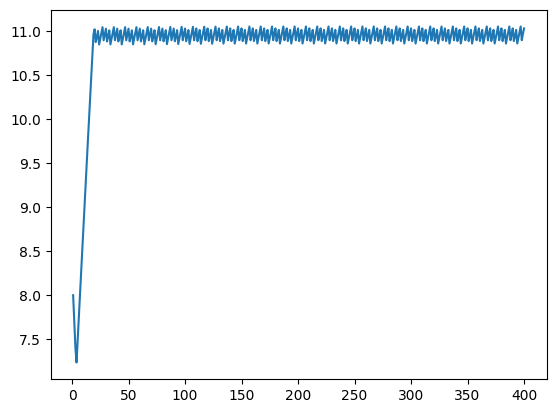

In [126]:
# Simulação

AndarAtual = 8
AndarDeslocado = 11

# Inicialização das variáveis de posição
posicao, posicaoAtual = [[AndarAtual], AndarAtual]

# Cálculo do erro inicial de altura
ErroAltura = AndarDeslocado - posicaoAtual

# Loop para simular o controle ao longo do tempo
for t in np.arange(0.1, 3, 0.1):
    # Cálculo da potência do motor com base no tempo
    PotenciaMotor = t * 0.315 / 3
    
    # Atualização da posição atual do elevador
    posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
    
    # Adiciona a posição atual ao array de posições
    if round(t, 1) == round(t):
        posicao = np.append(posicao, posicaoAtual)

# Cálculo do erro anterior de altura
ErroAnterior = AndarDeslocado - posicaoAtual

# Loop principal para simulação contínua
for _ in np.arange(3, 400, 1):
    # Cálculo do erro de altura e erro atual
    ErroAltura = AndarDeslocado - posicaoAtual
    ErroAtual = abs(ErroAltura)
    
    # Definição dos valores de entrada do sistema de controle fuzzy
    ControleVelocidade.input[Erro.label] = ErroAtual
    dErroAtual = ErroAnterior - ErroAtual
    ControleVelocidade.input[dErro.label] = dErroAtual
    
    # Cálculo do controle fuzzy
    ControleVelocidade.compute()
    
    # Determinação da potência do motor a ser aplicada
    PotenciaMotor = ControleVelocidade.output['PotenciaMotor']
    
    # Atualização da posição atual do elevador com base na potência do motor
    posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
    
    # Impressão dos resultados para visualização durante a simulação
    print(f'ErroAtual: {ErroAtual:.2f} dErroAtual: {dErroAtual:.2f} -> PotenciaMotor: {PotenciaMotor:.2f} -> posicaoAtual: {posicaoAtual:.2f}')
    
    # Adiciona a posição atual ao array de posições
    posicao = np.append(posicao, posicaoAtual)
    
    # Atualização do erro anterior de altura
    ErroAnterior = ErroAtual

plt.plot(np.arange(1, 401, 1), posicao)


### 11. Entrada e Saída de dados com valores estáticos

In [127]:
AndarAtual = 24
AndarDeslocado = 27

# Inicialização das variáveis de posição
posicao, posicaoAtual = [[AndarAtual], AndarAtual]

# Cálculo do erro inicial de altura
ErroAltura = AndarDeslocado - posicaoAtual
while True:
    # Loop para simular o controle ao longo do tempo
    for t in np.arange(0.1, 3, 0.1):
        # Cálculo da potência do motor com base no tempo
        PotenciaMotor = t * 0.315 / 3
        
        # Atualização da posição atual do elevador
        posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
        
        # Adiciona a posição atual ao array de posições
        if t == round(t, 0):
            posicao = np.append(posicao, posicaoAtual)

    # Cálculo do erro anterior de altura
    ErroAnterior = AndarDeslocado - posicaoAtual

    # Loop principal para simulação contínua
    for _ in np.arange(3, 400, 1):
        # Cálculo do erro de altura e erro atual
        ErroAltura = AndarDeslocado - posicaoAtual
        ErroAtual = abs(ErroAltura)
        
        # Definição dos valores de entrada do sistema de controle fuzzy
        ControleVelocidade.input[Erro.label] = ErroAtual
        dErroAtual = ErroAnterior - ErroAtual
        ControleVelocidade.input[dErro.label] = dErroAtual
        
        # Cálculo do controle fuzzy
        ControleVelocidade.compute()
        
        # Determinação da potência do motor a ser aplicada
        PotenciaMotor = ControleVelocidade.output['PotenciaMotor']

   
        posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
        time.sleep(0.5)
        
        # Adiciona a posição atual ao array de posições
        posicao = np.append(posicao, posicaoAtual)
        
        # Atualização do erro anterior de altura
        ErroAnterior = ErroAtual
        # Impressão dos resultados para visualização durante a simulação
        print(f'ErroAtual: {ErroAtual:.2f} dErroAtual: {dErroAtual:.2f} -> PotenciaMotor: {PotenciaMotor:.2f} -> posicaoAtual: {posicaoAtual:.2f}')
        client.publish("elevador/ErroAtual", payload=ErroAtual)
        client.publish("elevador/dErroAtual", payload=dErroAtual)
        client.publish("elevador/PotenciaMotor", payload=PotenciaMotor)
        client.publish("elevador/AndarAtual", payload=posicaoAtual)




ErroAtual: 5.59 dErroAtual: 0.00 -> PotenciaMotor: 11.52 -> posicaoAtual: 21.43


KeyboardInterrupt: 

### 11. Entrada e Saída de dados com valores dinâmicos

In [ ]:
# Função para simular o movimento do elevador e publicar no MQTT
def simular_movimento(altura_andar_atual, altura_andar_destino):
    global client
    # Inicializa a posição e a posição atual do elevador
    posicao, posicaoAtual = [[altura_andar_atual], altura_andar_atual]
    # Calcula o erro de altura inicial
    ErroAltura = altura_andar_destino - posicaoAtual

    # Simula o movimento do elevador ao longo do tempo
    for t in np.arange(0.1, 3, 0.1):
        # Calcula a potência do motor
        PotenciaMotor = t * 0.315 / 3
        # Atualiza a posição atual do elevador
        posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
        # Armazena a posição atual em intervalos de tempo inteiros
        if t == round(t, 0): posicao = np.append(posicao, posicaoAtual)

    # Armazena o erro de altura anterior
    ErroAnterior = altura_andar_destino - posicaoAtual

    # Função para iterar o movimento do elevador
    def movimento_iterativo(iteracao):
        nonlocal ErroAltura, ErroAnterior, posicaoAtual, posicao

        if iteracao < 400:
            # Calcula o erro de altura atual
            ErroAltura = altura_andar_destino - posicaoAtual
            ErroAtual = abs(ErroAltura)
            # Configura a entrada do controle de velocidade com o erro atual
            ControleVelocidade.input[Erro.label] = ErroAtual
            # Calcula a diferença de erro atual
            dErroAtual = ErroAnterior - ErroAtual
            # Configura a entrada do controle de velocidade com a diferença de erro
            ControleVelocidade.input[dErro.label] = dErroAtual
            # Calcula a nova saída de controle
            ControleVelocidade.compute()
            PotenciaMotor = ControleVelocidade.output['PotenciaMotor']
            # Atualiza a posição atual do elevador
            posicaoAtual = abs(posicaoAtual * 0.996 * (1 if ErroAltura > 0 else -1) + PotenciaMotor * 0.00951)
            print(f'ErroAtual: {ErroAtual:.2f} dErroAtual: {dErroAtual:.2f} -> PotenciaMotor: {PotenciaMotor:.2f} -> posicaoAtual: {posicaoAtual:.2f}')

            # Publica os valores no MQTT
            client.publish("elevador/ErroAtual", payload=ErroAtual)
            client.publish("elevador/dErroAtual", payload=dErroAtual)
            client.publish("elevador/PotenciaMotor", payload=PotenciaMotor)
            client.publish("elevador/AndarAtual", payload=posicaoAtual)
            posicao = np.append(posicao, posicaoAtual)
            # Atualiza o erro anterior
            ErroAnterior = ErroAtual

            # Agendar a próxima iteração
            root.after(500, movimento_iterativo, iteracao + 1)
        else:
            # Movimento completo
            pass

    # Iniciar a primeira iteração
    root.after(500, movimento_iterativo, 0)

# Função para processar a escolha do usuário
def processar_escolha(opcao):
    global andar_atual, andar_destino, mapeamento_andares, alturas_andares, frame_destino, label_andar_atual

    # Extrai o andar escolhido
    andar_escolhido = opcao.split('_')[1]
    
    # Habilita o botão do andar anteriormente selecionado, se houver
    if andar_atual:
        for widget in frame_destino.winfo_children():
            if widget.cget('text') == andar_atual:
                widget.configure(state=tk.NORMAL)
            
            # Atualiza o andar de destino e calcula a altura dos andares
    andar_destino = andar_escolhido
    altura_andar_atual = alturas_andares[mapeamento_andares[andar_atual][1]]
    altura_andar_destino = alturas_andares[mapeamento_andares[andar_destino][1]]
    deslocamento = altura_andar_destino - altura_andar_atual
    direcao = "subindo" if deslocamento >= 0 else "descendo"
    
    # Exibe uma mensagem com informações sobre o destino
    messagebox.showinfo("Informação", f"Andar de destino selecionado: {mapeamento_andares[andar_destino][1]} (Deslocamento em metros: {abs(deslocamento)} {direcao})")

    # Desabilita o botão do andar de destino selecionado
    for widget in frame_destino.winfo_children():
        if widget.cget('text') == andar_destino:
            widget.configure(state=tk.DISABLED)

    # Limpa a saída do terminal para melhorar a visualização
    clear_output(wait=False)

    # Simula o movimento do elevador
    simular_movimento(altura_andar_atual, altura_andar_destino)

    # Atualiza o andar atual para o andar de destino
    andar_atual = andar_destino

    # Atualiza o texto do andar atual na interface
    label_andar_atual.config(text=f"Andar atual: {mapeamento_andares[andar_atual][1]}")

# Criando a janela principal
root = tk.Tk()
root.title("Elevador")

# Definindo variáveis globais para armazenar a escolha do usuário
andar_atual = 'T'  # Iniciar com 'T' como o andar atual
andar_destino = None
distancia_andar = 3  # Distância entre cada andar em metros

# Dicionário para mapear letras para números de andares e suas alturas correspondentes
mapeamento_andares = {
    'T': (4, 0),    # Altura, andar correspondente
    '1': (8, 1),
    '2': (11, 2),
    '3': (14, 3),
    '4': (17, 4),
    '5': (20, 5),
    '6': (23, 6),
    '7': (26, 7),
    '8': (29, 8)
}

# Ajustando alturas_andares para acessar a altura correta de cada andar
alturas_andares = {andar: altura for altura, andar in mapeamento_andares.values()}

# Frame para os botões do andar de destino
frame_destino = tk.LabelFrame(root, text="Andar de Destino")
frame_destino.pack(padx=10, pady=10)

# Botões do andar de destino
opcoes_destino = ["T", "1", "2", "3", "4", "5", "6", "7", "8"]
for opcao in opcoes_destino:
    botao = tk.Button(frame_destino, text=f"{opcao}", command=lambda opcao=opcao: processar_escolha(f"Destino_{opcao}"))
    botao.pack(fill=tk.X, padx=10, pady=5)
    if opcao == 'T':
        botao.configure(state=tk.DISABLED)

# Label para mostrar o andar atual
label_andar_atual = tk.Label(root, text=f"Andar atual: {mapeamento_andares[andar_atual][1]}", pady=10)
label_andar_atual.pack()

# Rodando o loop principal do tkinter
root.mainloop()
